In [31]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.time import Time
import healpy as hp

plt.style.use('~/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

h3 = Table.read('/Users/vedantchandra/0_research/data/h3/rcat_V4.0.5.d20221116_MSG.h5')

In [10]:
hgiants = (

    (h3['FLAG'] == 0)&
    (h3['logg'] < 3.5)&
    (h3['SNR'] > 3)

)

In [11]:
catalog = 'mage'
version = 'V0.03'

In [12]:
mage = Table.read('/Users/vedantchandra/0_research/data/mage/catalogs/%s_rcat_%s_MSG.fits' % (catalog, version))

In [13]:
print(len(mage))

296


### Survey Progress

In [62]:
mage['year'] = Time(mage['mage_mjd'], format = 'mjd').jyear

In [63]:
last_time = Time(mage['mage_mjd'], format = 'mjd').iso[-1][:10]

In [64]:
title = 'MagE (%s)' % last_time

In [77]:
clean = (

    (mage['Vrot'] < 50)&
    (mage['tdb_selection'] != 'kd6')&
    (mage['tdb_selection'] != 'rvs')&
    (mage['tdb_selection'] != 'tell')&
    (mage['tdb_selection'] != 'eri')&
    (mage['tdb_selection'] != 'h3')&
    (mage['tdb_selection'] != 'pictdg')&
    (mage['tdb_selection'] != 'pscdg')

)

print(len(clean))
print(np.sum(clean))

296
225


In [78]:
np.unique(mage[clean]['tdb_selection'])

d100
d80
d90
pscpl1
pscpl2
pscpl3


In [79]:
d50 = clean & (mage['Dist'] > 50)
d100 = clean & (mage['Dist'] > 100)

In [80]:
def get_obscurve(tab):
    cts,obsdates = np.histogram(tab['mage_mjd'], bins = 10000, 
                                range = (mage['mage_mjd'].min(), 
                                         mage['mage_mjd'].max()))
    times = Time(obsdates, format = 'mjd')
    years = times.jyear
    
    return years[:-1], np.cumsum(cts)

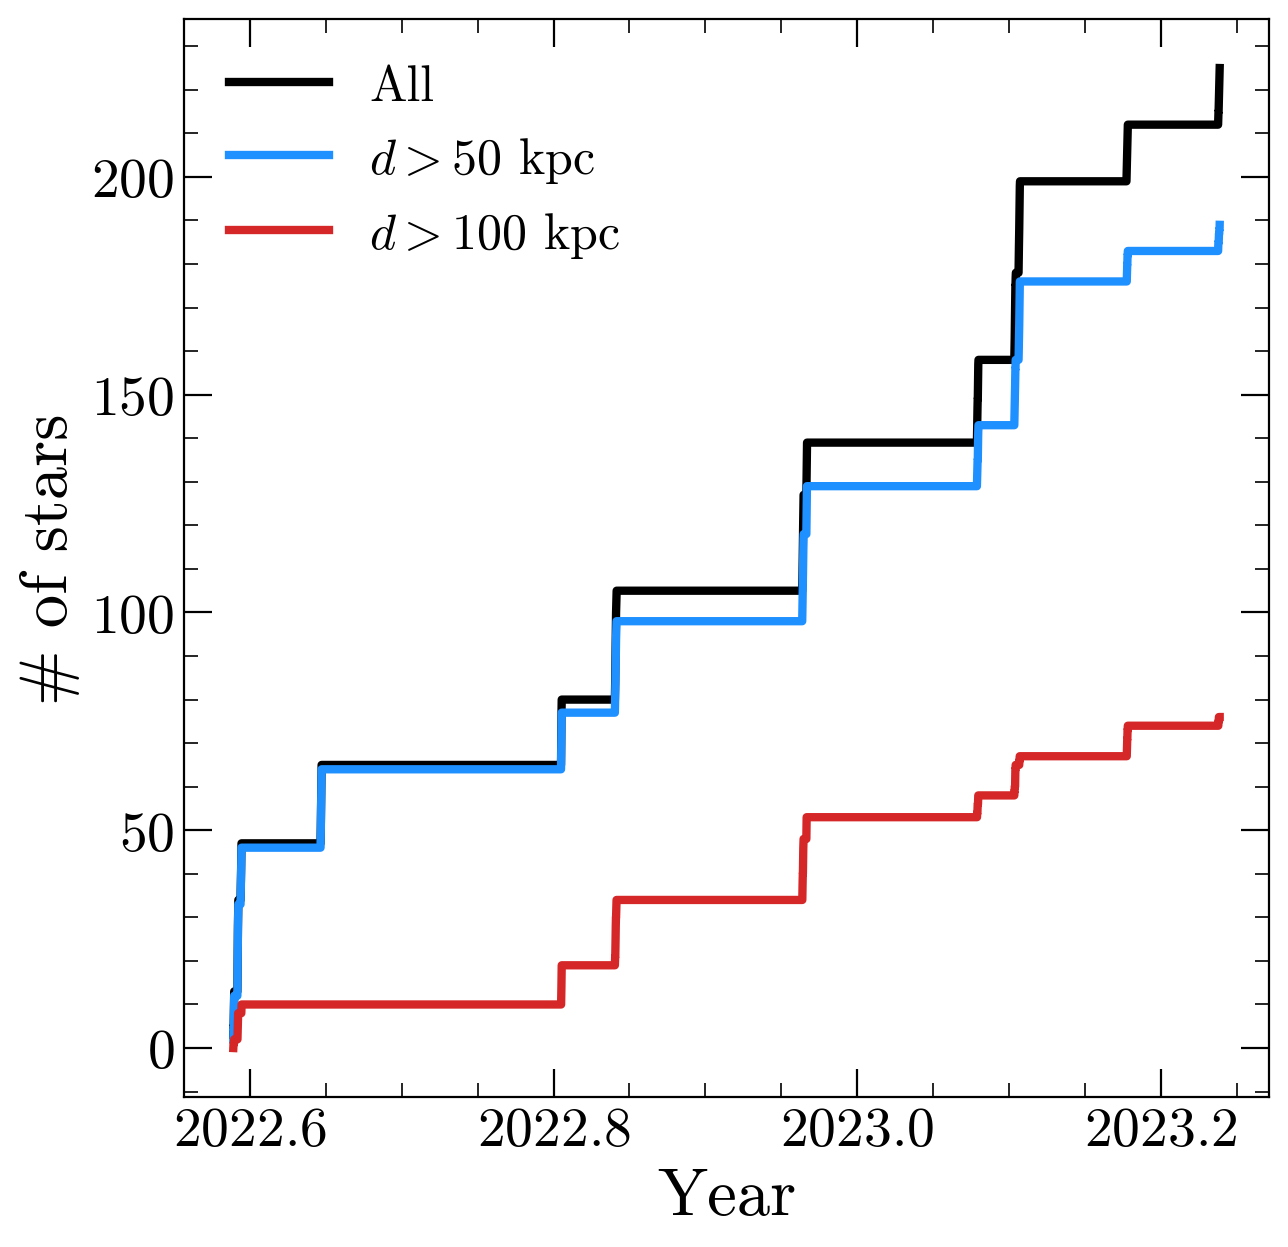

In [81]:
plt.plot(*get_obscurve(mage[clean]), color = 'k', lw = '3', label = 'All')
plt.plot(*get_obscurve(mage[d50]), color = 'dodgerblue', lw = '3', label = '$d > 50$ kpc')
plt.plot(*get_obscurve(mage[d100]), color = 'C3', lw = '3', label = '$d > 100$ kpc')

plt.xlabel('Year')
plt.ylabel('# of stars')

plt.legend(loc = 'upper left', framealpha = 0)
#plt.title(title)

plt.savefig('fig/cumulative_nstars.pdf')

0.0 180.0 -180.0 180.0


Text(0.5, 0, 'Year')

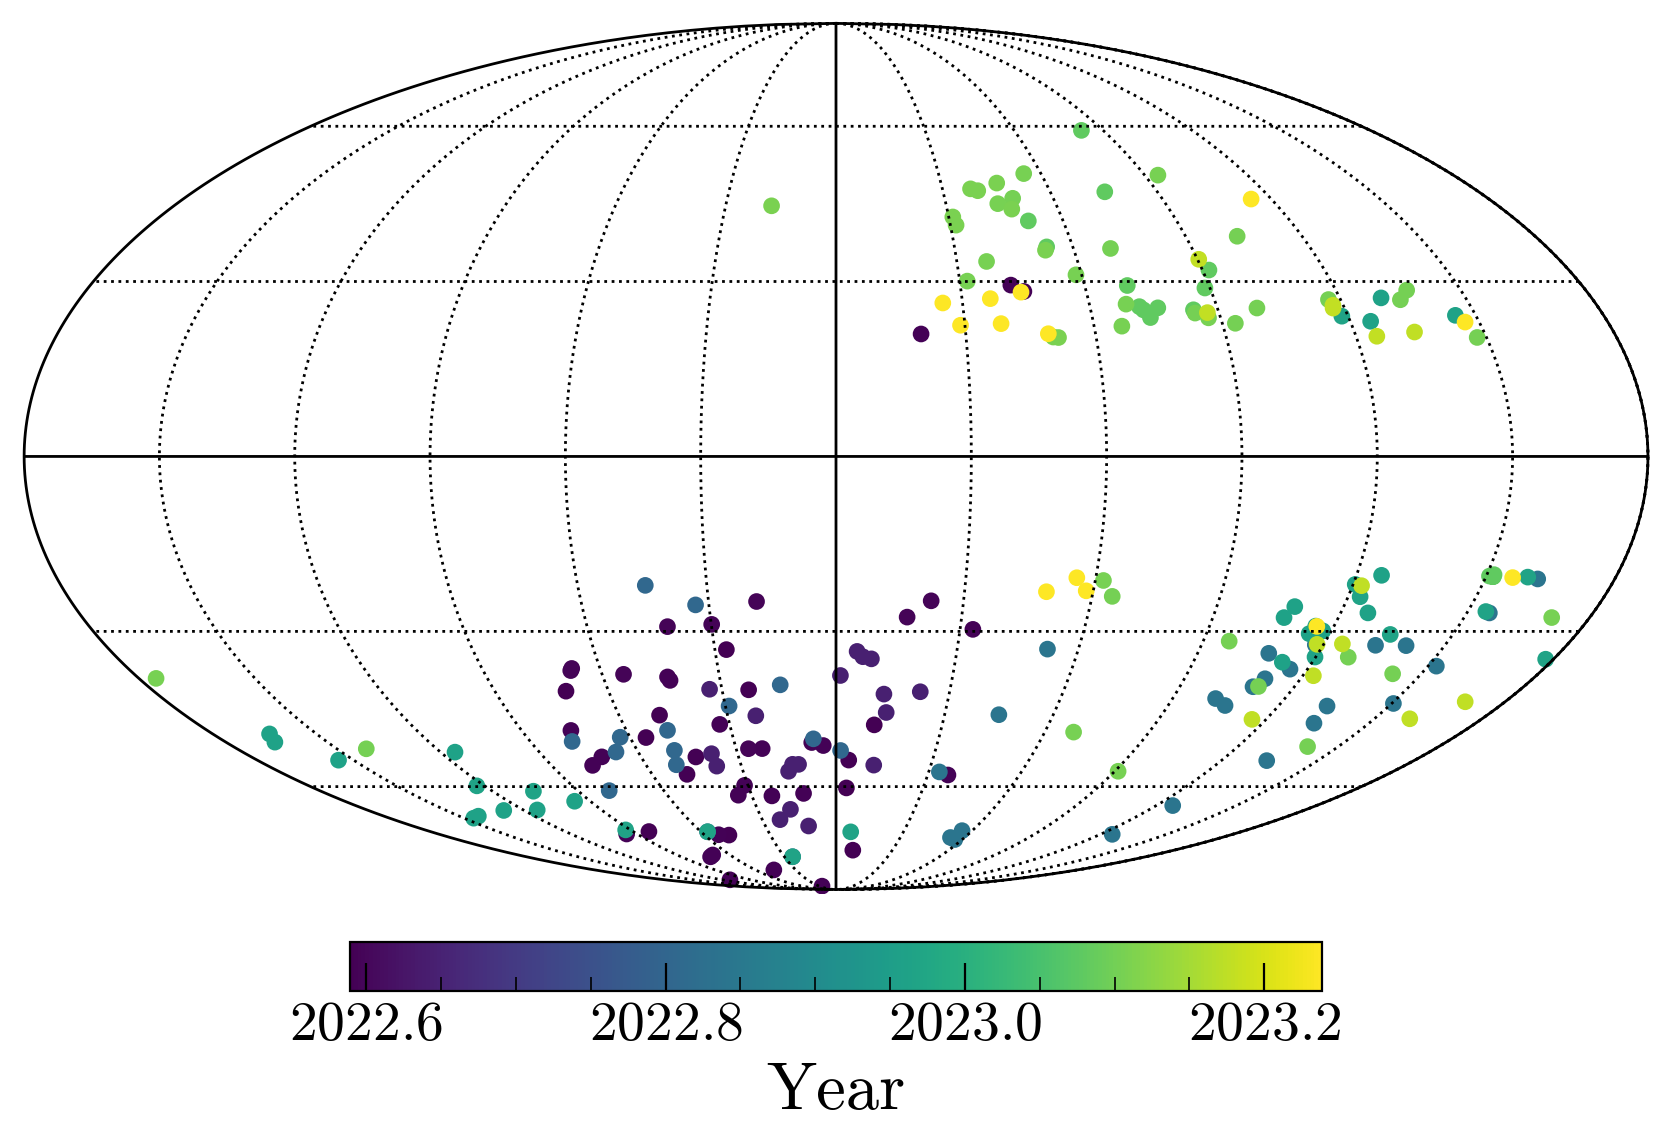

In [82]:
hp.mollview()
im = hp.projscatter(mage[clean]['L'], mage[clean]['B'], lonlat = True, 
              c = mage[clean]['year'], cmap = 'viridis')
hp.graticule()
cbar = plt.colorbar(im, location = 'bottom', orientation = 'horizontal',
            fraction = 0.05, pad = 0.05)
plt.title('')
cbar.ax.set_xlabel('Year')

In [90]:
mage[clean][(mage[clean]['B'] > 0) & (mage[clean]['L'] > 0) & ((mage[clean]['L'] < 30))]

name,date,specfile,mage_ra,mage_dec,mage_target,mage_decker,mage_binning,mage_mjd,mage_airmass,mage_exptime,tdb_source_id,tdb_ra,tdb_dec,tdb_selection,H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,GAIAEDR3_ID,GAIADR1_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,UNWISE_W1,UNWISE_W2,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,WISE_CC_FLAGS,WISE_EXT_FLAG,ACAT_ID,EEP,EEP_lerr,EEP_uerr,EEP_err,init_FeH,init_FeH_lerr,init_FeH_uerr,init_FeH_err,init_aFe,init_aFe_lerr,init_aFe_uerr,init_aFe_err,init_Mass,init_Mass_lerr,init_Mass_uerr,init_Mass_err,pc_0,pc_0_lerr,pc_0_uerr,pc_0_err,pc_1,pc_1_lerr,pc_1_uerr,pc_1_err,pc_2,pc_2_lerr,pc_2_uerr,pc_2_err,pc_3,pc_3_lerr,pc_3_uerr,pc_3_err,Inst_R,Inst_R_lerr,Inst_R_uerr,Inst_R_err,Teff,Teff_lerr,Teff_uerr,Teff_err,logg,logg_lerr,logg_uerr,logg_err,logR,logR_lerr,logR_uerr,logR_err,FeH,FeH_lerr,FeH_uerr,FeH_err,aFe,aFe_lerr,aFe_uerr,aFe_err,Vrad,Vrad_lerr,Vrad_uerr,Vrad_err,Vrot,Vrot_lerr,Vrot_uerr,Vrot_err,Dist,Dist_lerr,Dist_uerr,Dist_err,Av,Av_lerr,Av_uerr,Av_err,logAge,logAge_lerr,logAge_uerr,logAge_err,Mass,Mass_lerr,Mass_uerr,Mass_err,logL,logL_lerr,logL_uerr,logL_err,Para,Para_lerr,Para_uerr,Para_err,Age,Age_lerr,Age_uerr,Age_err,lnZ,lnL,lnP,chisq_spec,nspecpix,chisq_phot,nbands,spec_snr,R_gal,R_gal_err,X_gal,X_gal_err,Y_gal,Y_gal_err,Z_gal,Z_gal_err,Vx_gal,Vx_gal_err,Vy_gal,Vy_gal_err,Vz_gal,Vz_gal_err,Vr_gal,Vr_gal_err,Vphi_gal,Vphi_gal_err,Vtheta_gal,Vtheta_gal_err,V_tan,V_tan_err,V_gsr,V_gsr_err,Lx,Lx_err,Ly,Ly_err,Lz,Lz_err,Ltot,Ltot_err,E_kin_pot1,E_kin_pot1_err,E_pot_pot1,E_pot_pot1_err,E_tot_pot1,E_tot_pot1_err,circLz_pot1,circLz_pot1_err,circLtot_pot1,circLtot_pot1_err,FLAG,dup,Sgr_l,Sgr_b,Sgr_FLAG,year
bytes32,bytes10,bytes84,float64,float64,bytes10,bytes3,bytes3,float64,float64,float64,int64,float64,float64,bytes6,int32,int32,bytes17,bytes19,bytes16,int64,int32,bytes8,float64,float64,bytes11,bytes12,float64,float64,float64,int16,int16,float64,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes4,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64

In [91]:
def gtrhist(x, dbins):
    counts = [];

    for ii in range(len(dbins)):
        di = dbins[ii]
        counts.append(np.sum(x > di))

    counts = np.array(counts)
    
    return counts

dbins = np.linspace(1, 160, 100)

In [92]:
nstar_mage = gtrhist(mage[clean]['Dist'], dbins)
nstar_h3 = gtrhist(h3['dist_adpt'][hgiants], dbins)
# nstar_gaia = gtrhist(tab2['r_med_geo'] / 1000, dbins)

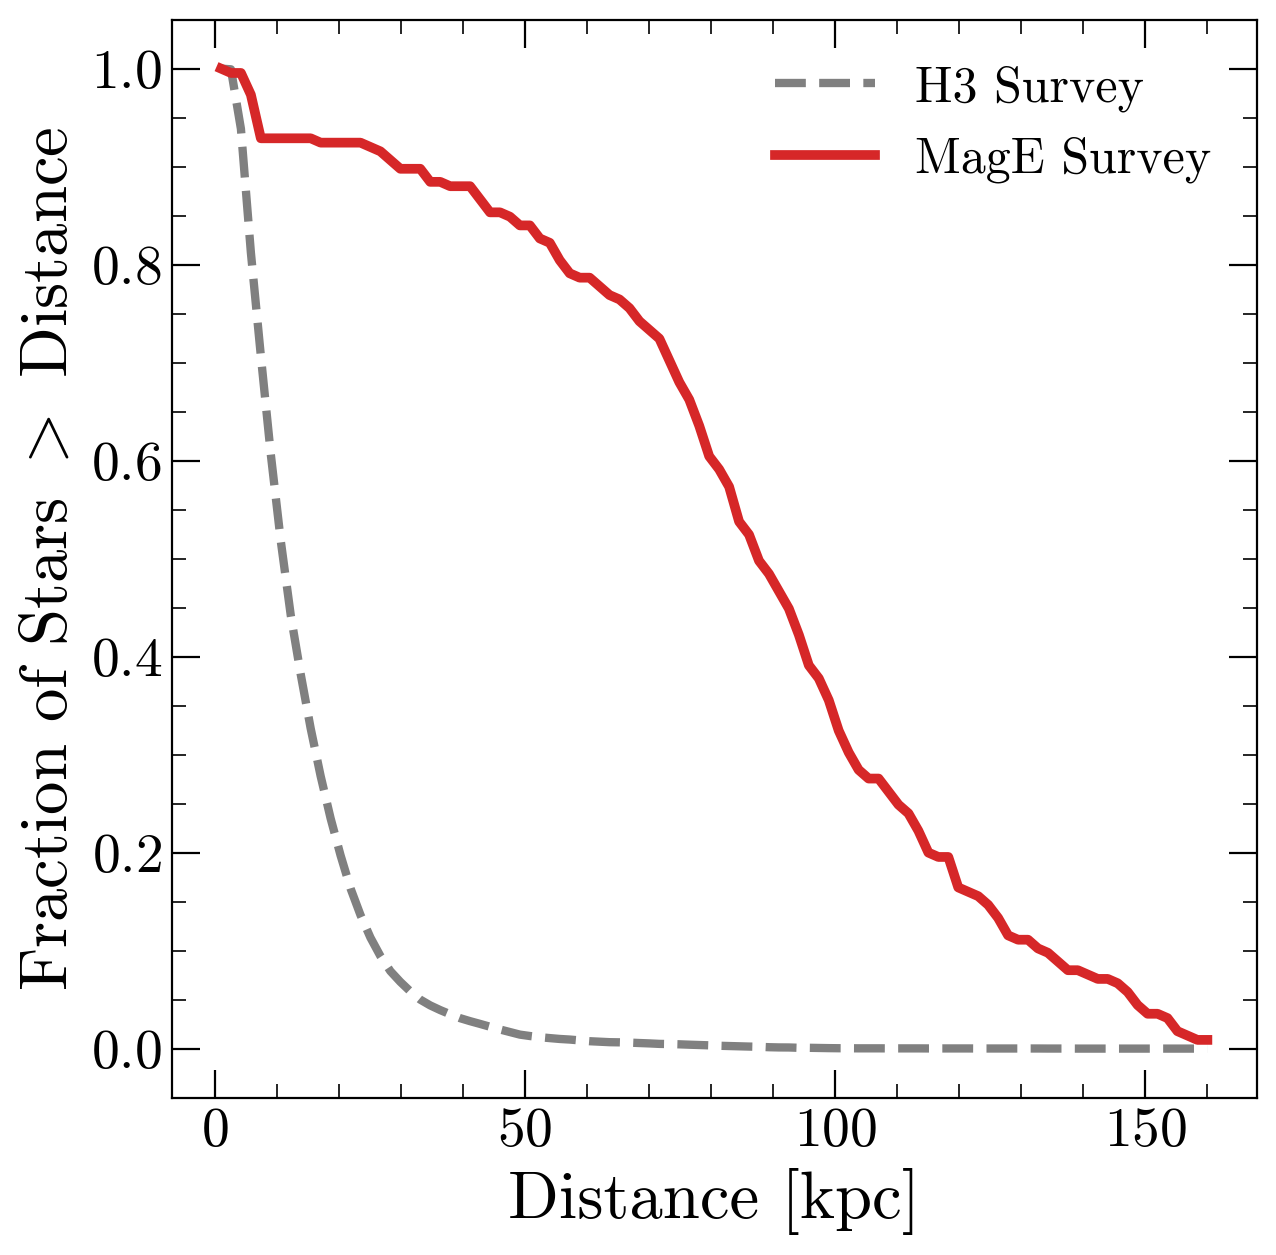

In [94]:
# plt.plot(dbins, nstar_gaia / np.max(nstar_gaia), color = 'darkgray', lw = 2.5, ls = ':', label = 'Gaia DR3')
plt.plot(dbins, nstar_h3 / np.max(nstar_h3), color = 'gray', lw = 3, ls = '--', label = 'H3 Survey')
plt.plot(dbins, nstar_mage / np.max(nstar_mage), color = 'C3', lw = 3.5, label = 'MagE Survey')



#plt.yscale('log')
#plt.xscale('log')

plt.legend(framealpha = 0)

plt.ylabel('Fraction of Stars $>$ Distance')
plt.xlabel('Distance [kpc]')

plt.savefig('fig/distance_h3comp.pdf')

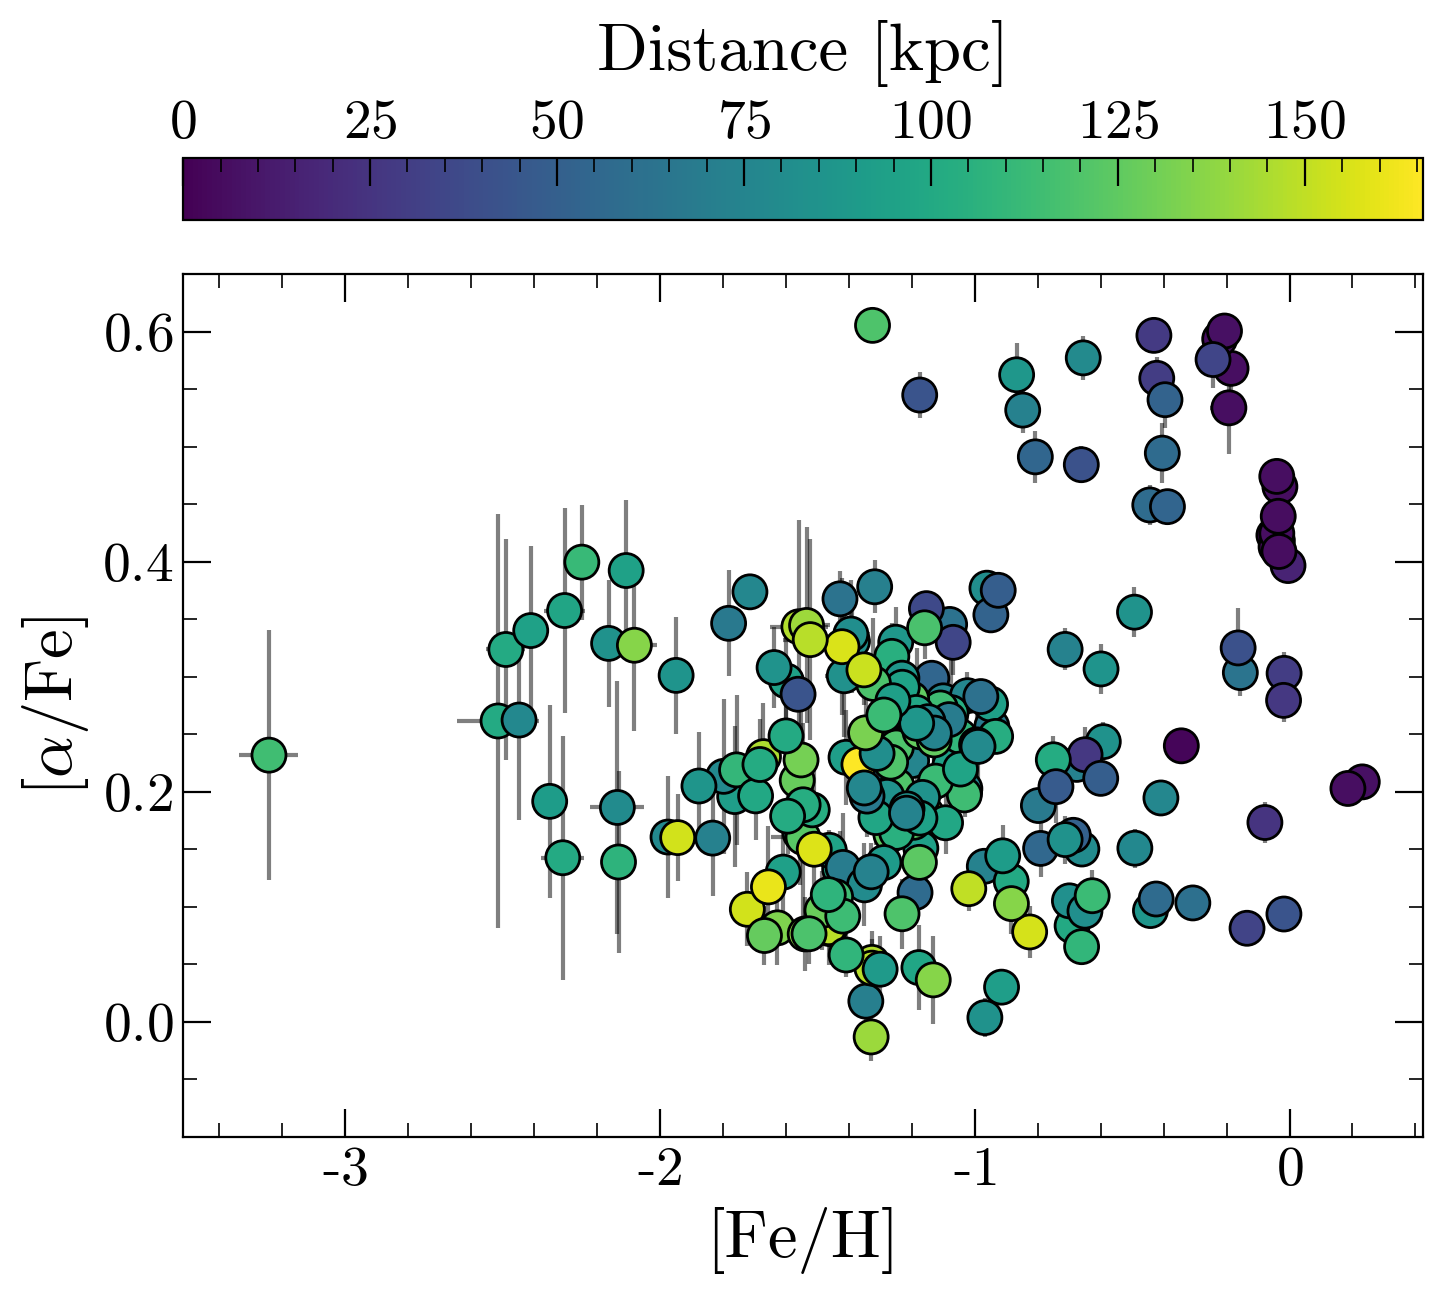

In [106]:
plt.figure(figsize = (8, 7))
plt.scatter(mage[clean]['FeH'], mage[clean]['aFe'], 
            c = mage[clean]['Dist'], cmap = 'viridis', s = 150, edgecolor = 'k',
           vmin = 0)
plt.errorbar(mage[clean]['FeH'], mage[clean]['aFe'], xerr = mage[clean]['FeH_err'],
             yerr = mage[clean]['aFe_err'], 
             linestyle = 'none', zorder = 0, ecolor = 'k', alpha = 0.5)

plt.xlabel('[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.ylim(-0.1, 0.65)
cbar = plt.colorbar(location = 'top', orientation = 'horizontal')
cbar.ax.set_xlabel('Distance [kpc]', labelpad = 10.5)

plt.savefig('fig/tw_distance.pdf')

### Other Plots

In [75]:
far = mage['Dist'] > 40

In [93]:
lmc = [280, -32]
smc = [302, -44]
lmc_orb = np.genfromtxt('ngc21_LMC_orbit.txt')
lmc_orbl = lmc_orb[:, 3]
lmc_orbb = lmc_orb[:, 4]
orbsel = lmc_orbb < -20
plume_l = np.array([-25, 100])
plume_b = np.array([-90, -30])

In [104]:
from astropy.coordinates import Angle
from astropy import units as u

In [107]:
mage['lw'] = Angle(mage['L'] * u.deg).wrap_at('180d').value
mage['pl'] = np.array(['pscpl' in sel for sel in mage['tdb_selection']])
c1 = -40
c2 = 2
pl = (
    clean & 
    (mage['pl'])&
    (mage['lw'] < 60)&
#     ((table['lw'] > 10))&
    (mage['B'] > -70)&
    (mage['B'] < c1 + c2 * mage['lw'])
#     (table['b' ] < 0)&
#     (table['Dist'] < 90)
)


0.0 180.0 -180.0 180.0


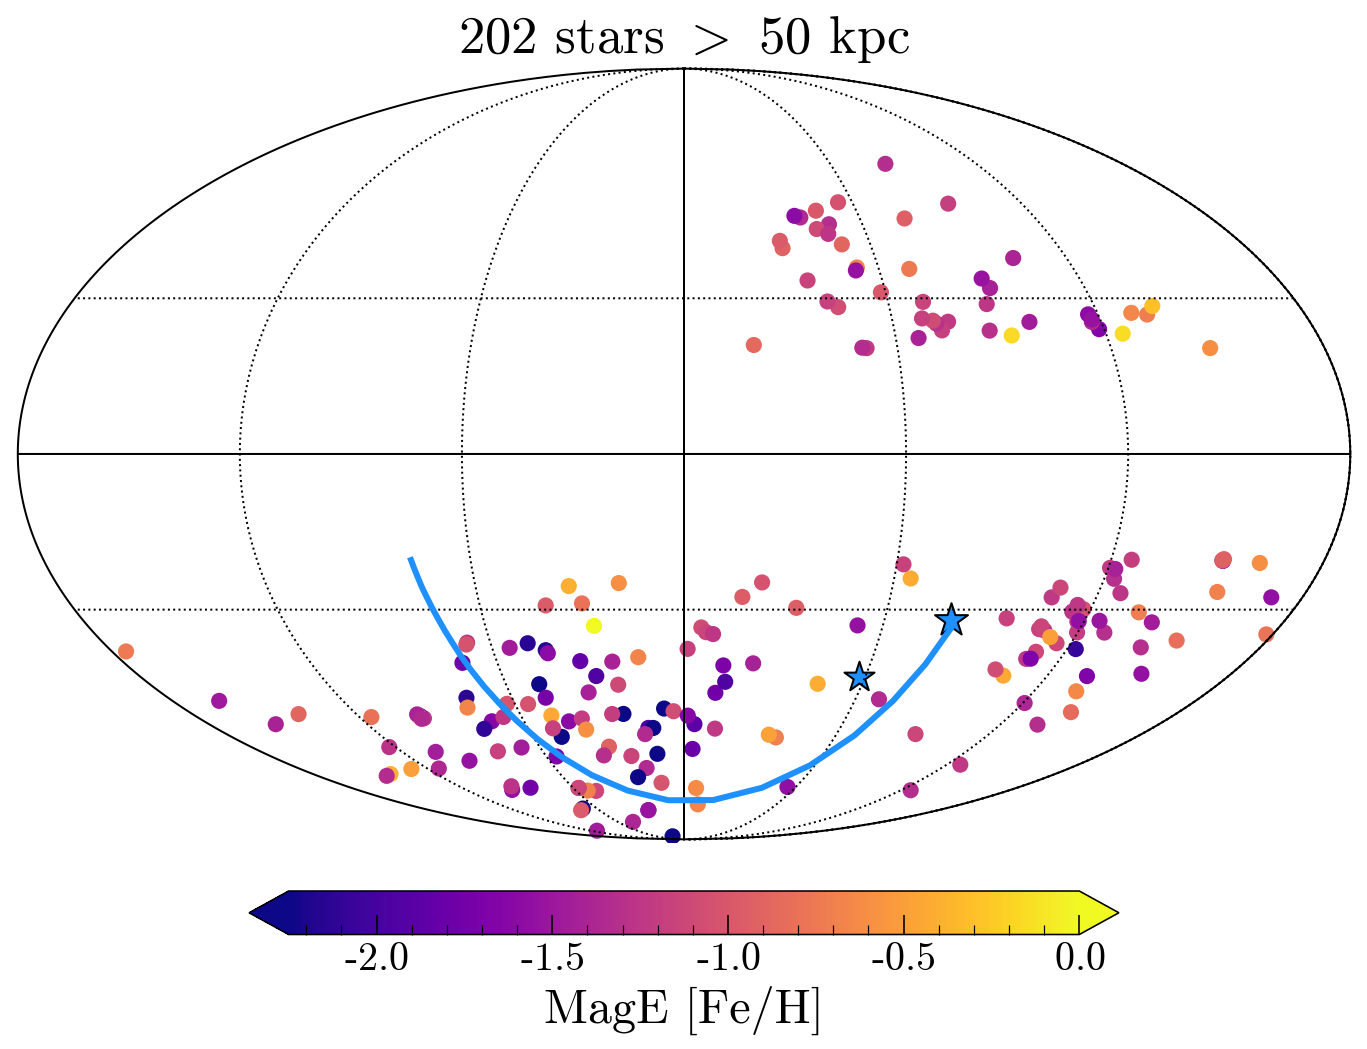

In [110]:
plt.figure(figsize = (12,8))
hp.mollview(hold = True)
hp.graticule(dpar = 60)

im = hp.projscatter(mage[clean&far]['L'], mage[clean&far]['B'], lonlat = True, s = 50, 
              c = mage[clean&far]['FeH'], cmap = 'plasma', vmin = -2.25, vmax = 0)
plt.title('%s stars $>$ 50 kpc' % np.sum(clean&far))

cbar = plt.colorbar(im, location = 'bottom', orientation = 'horizontal', fraction = 0.05, pad = 0.055, extend = 'both')
cbar.ax.set_xlabel('MagE [Fe/H]')

hp.projplot(lmc_orbl[orbsel], lmc_orbb[orbsel], coord = 'G', lonlat = True, color = 'dodgerblue',
           lw = 3, ls = '-')

# hp.projscatter(mage[pl]['L'], mage[pl]['B'], lonlat = True)

hp.projscatter(lmc[0], lmc[1], coord = 'G', lonlat = True, marker = '*', s = 300, edgecolor = 'k',
              color = 'dodgerblue', label = 'LMC')

hp.projscatter(smc[0], smc[1], coord = 'G', lonlat = True, marker = '*', s = 250, edgecolor = 'k',
              color = 'dodgerblue', label ='SMC')

In [114]:
ekw = dict(linestyle = 'none', marker = 'o', color = 'k', 
          capsize = 0)

In [123]:
from astropy.io import ascii

In [126]:
h21_smc = ascii.read('plume/smc.csv')
h21_lmc = ascii.read('plume/lmc.csv')
h21_gse = ascii.read('plume/gse.csv')
from scipy.interpolate import UnivariateSpline as Spline

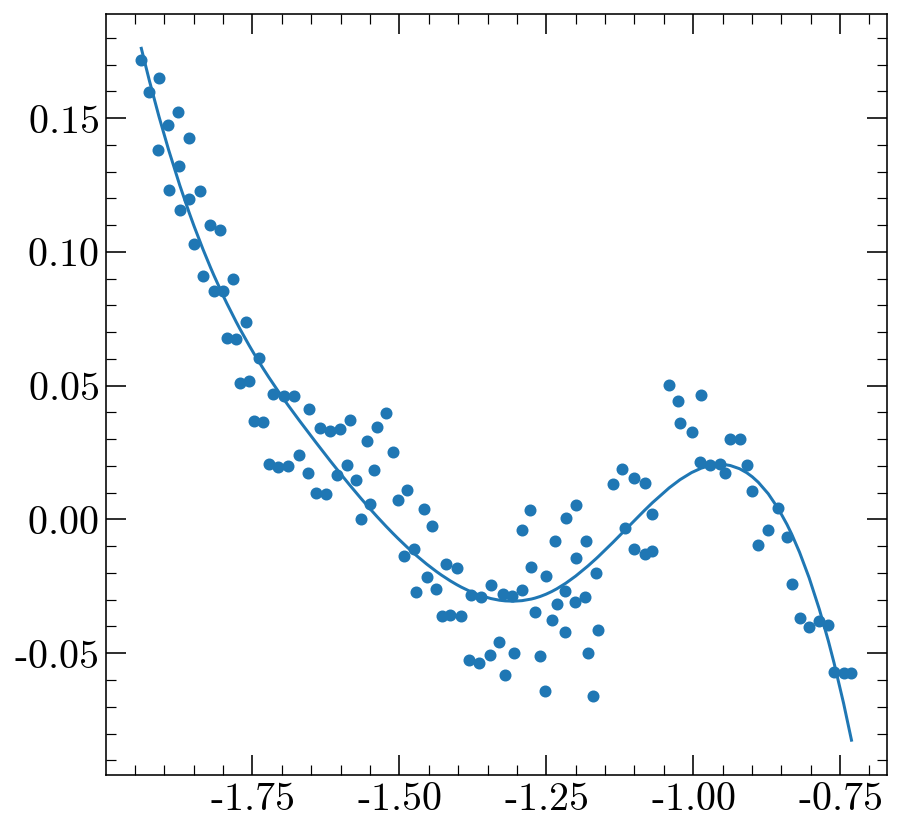

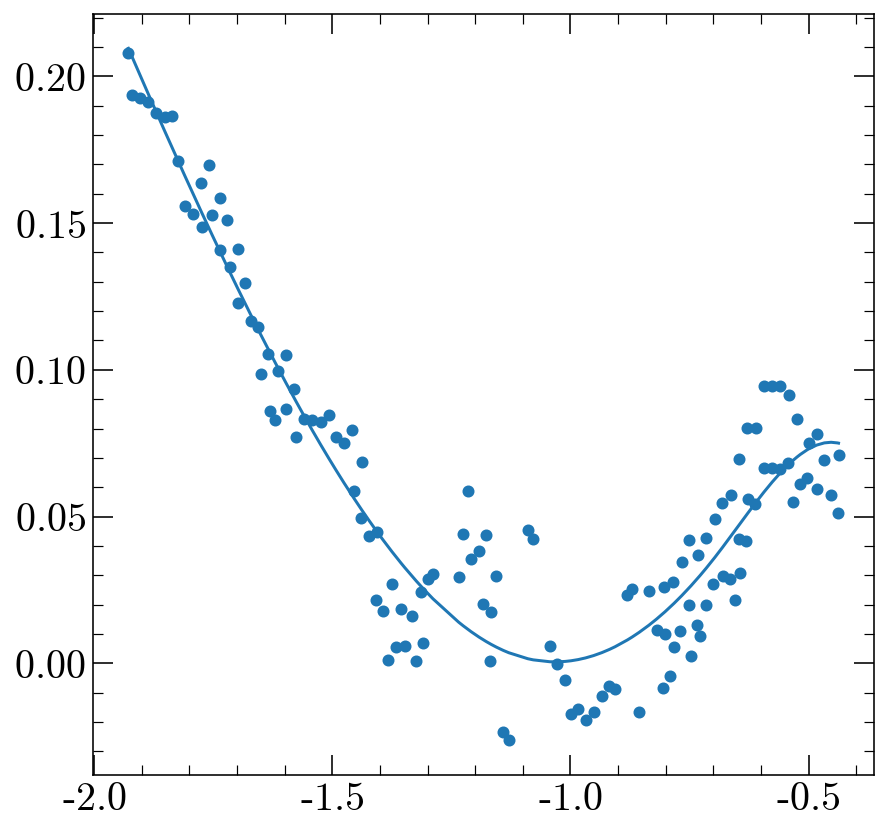

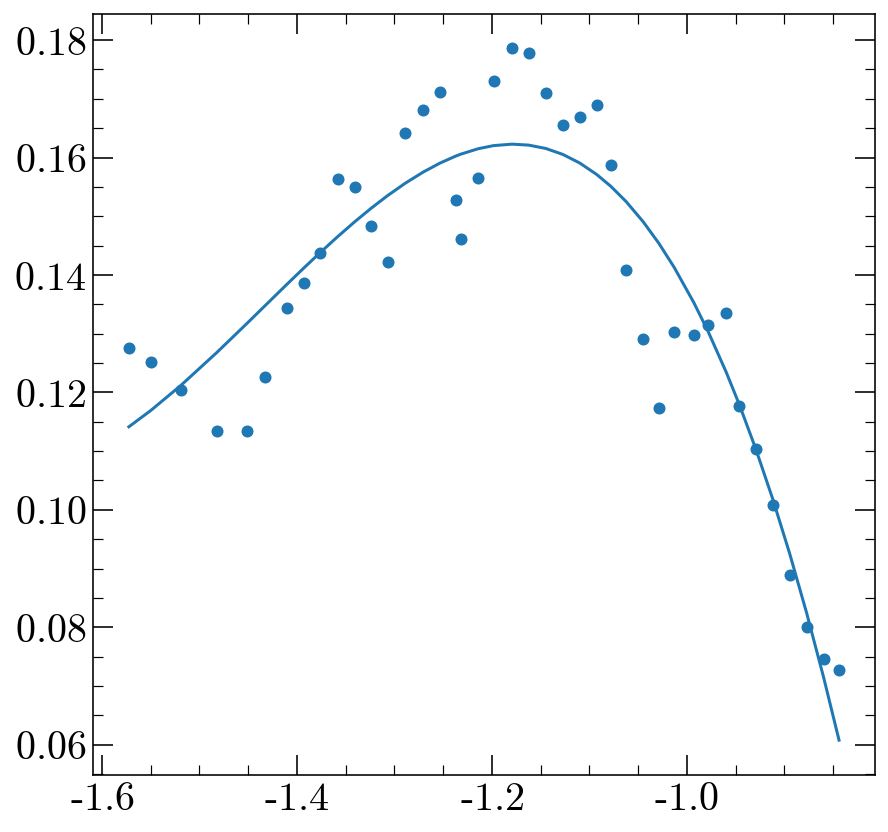

In [127]:
for tab in [h21_smc, h21_lmc, h21_gse]:
    x = tab['col1']
    y = tab['col2']
    
    spl = Spline(x, y, s = 4e-2)

    tab['col3'] = spl(x)

    plt.scatter(tab['col1'], tab['col2'])
    plt.plot(x, tab['col3'])
    plt.show()

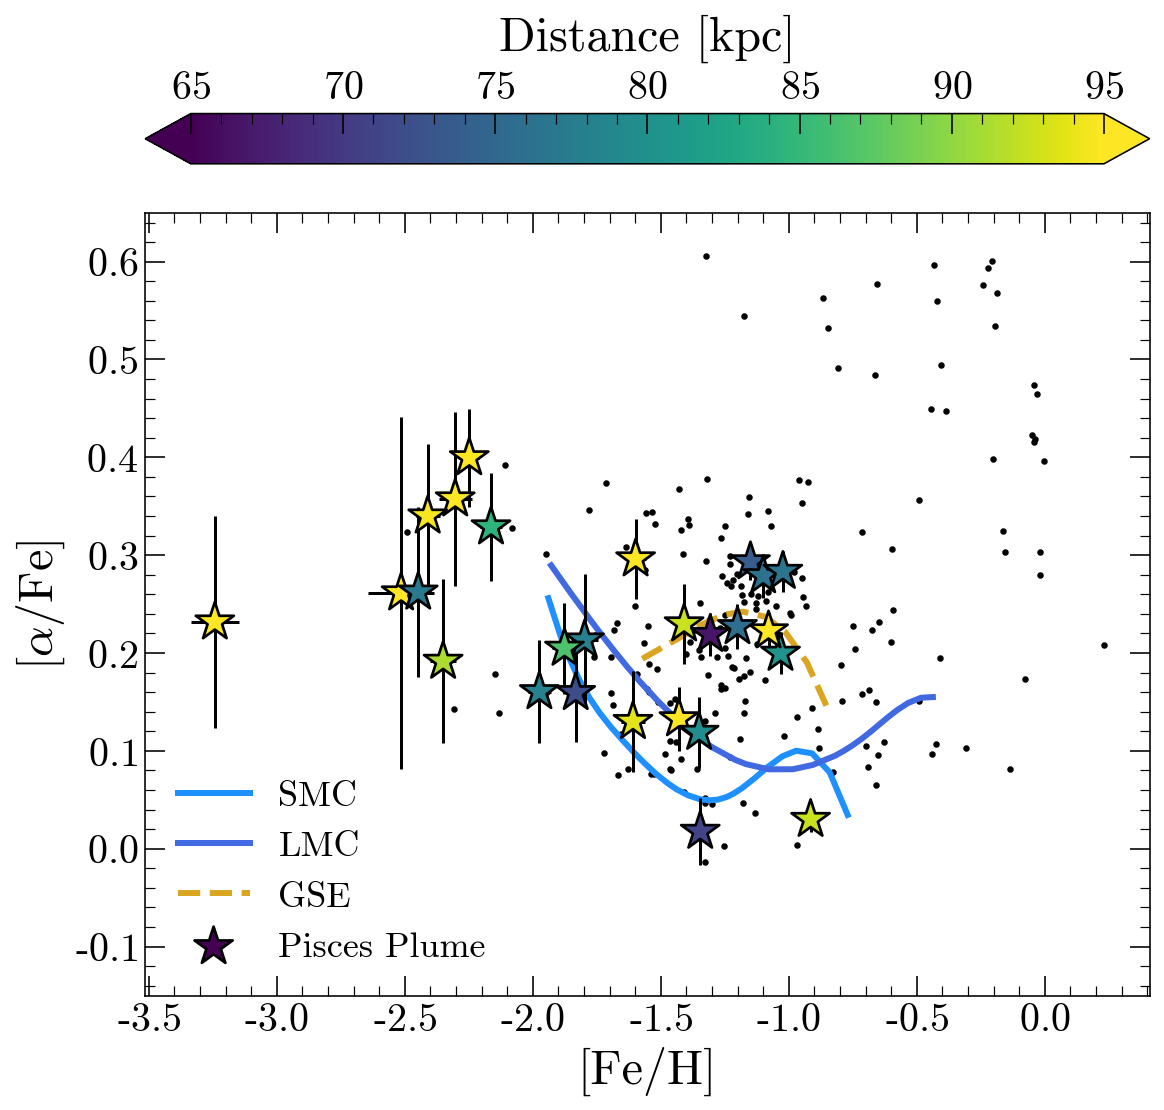

In [147]:
plt.figure(figsize = (9, 9))

sk = 5
afac = 0.08
plt.plot(h21_smc['col1'][::sk], h21_smc['col3'][::sk] + afac, color = 'dodgerblue', ls = '-', lw = 3,
        label = 'SMC')
plt.plot(h21_lmc['col1'][::sk], h21_lmc['col3'][::sk] + afac, color = 'royalblue', ls = '-', lw = 3,
        label = 'LMC')
plt.plot(h21_gse['col1'][::sk], h21_gse['col3'][::sk] + afac, color = 'goldenrod', ls = '--', lw = 3,
        label = "GSE")

plt.scatter(mage[clean]['FeH'], mage[clean]['aFe'], color = 'k', s = 5
)

plt.errorbar(mage[pl]['FeH'], mage[pl]['aFe'],
            xerr = mage[pl]['FeH_err'], yerr = mage[pl]['aFe_err'],
            **ekw)

plt.scatter(mage[pl]['FeH'], mage[pl]['aFe'], c = mage[pl]['Dist'],
           s = 400, cmap = 'viridis', edgecolor = 'k', zorder = 10, vmin = 65, vmax = 95,
           label = 'Pisces Plume', marker = '*', linewidth = 1.35)

plt.ylim(-0.15, 0.65)

cbar = plt.colorbar(location = 'top', orientation = 'horizontal', extend = 'both')
cbar.ax.set_xlabel('Distance [kpc]', labelpad = 10.5)
plt.xlabel('[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.legend(loc = 'lower left', framealpha = 0)

### Comparison To H3

In [3]:
for key in list(h3.columns):
    h3.rename_column(key, 'h3_' + key)

In [4]:
h3['GAIAEDR3_ID'] = h3['h3_GAIAEDR3_ID']

In [5]:
mage = Table.read('/n/holyscratch01/conroy_lab/vchandra/mage/catalogs/h3cal_rcat_V0.0_MSG.fits')

In [6]:
table = astropy.table.join(mage, h3, keys = 'GAIAEDR3_ID', join_type = 'left')

In [7]:
table['h3_Dist'] = table['h3_dist_adpt']
table['h3_Dist_err'] = table['h3_dist_adpt_err']

In [8]:
clean = (

    (table['h3_FLAG'] == 0)&
    (table['Vrot'] < 20)

)

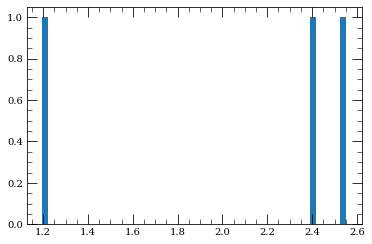

In [9]:
plt.hist(table[clean]['Vrot'], bins = 50);

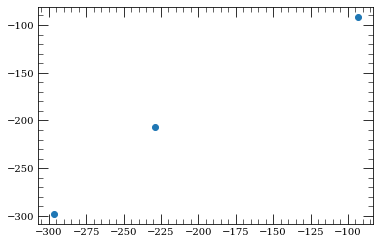

In [11]:
plt.scatter(table['h3_Vrad'][clean], table['Vrad'][clean])

In [12]:
ekw = dict(linestyle = 'none', marker = 'o', color = 'k', ecolor = 'gray', capsize = 0)
fs = 22

In [13]:
def comp(x):
    mins = np.nanmin([np.nanmin(table['h3_' + x][clean]), 
                                 np.nanmin(table[x][clean])])
    maxs = np.nanmax([np.nanmax(table['h3_' + x][clean]), 
                                 np.nanmax(table[x][clean])])
    lims = [mins - 0.1 * np.abs(mins), maxs + 0.1 * np.abs(maxs)]
    
    diff =  table[x][clean] - table['h3_' + x][clean]
    
    mad = np.median(np.abs(diff))
    bias = np.median(diff)

    plt.errorbar(table['h3_' + x][clean], table[x][clean],
                xerr = table['h3_' + x + '_err'][clean], yerr = table[x + '_err'][clean], **ekw)

    plt.plot(lims, lims, 'C3')
    plt.title('MAD: %.2f, Bias: %.2f' % (mad, bias), fontsize = fs)
    
    plt.xlim(lims)
    plt.ylim(lims)
    
    #if x == 'Dist':
    #    plt.xscale('log')
    #    plt.yscale('log')

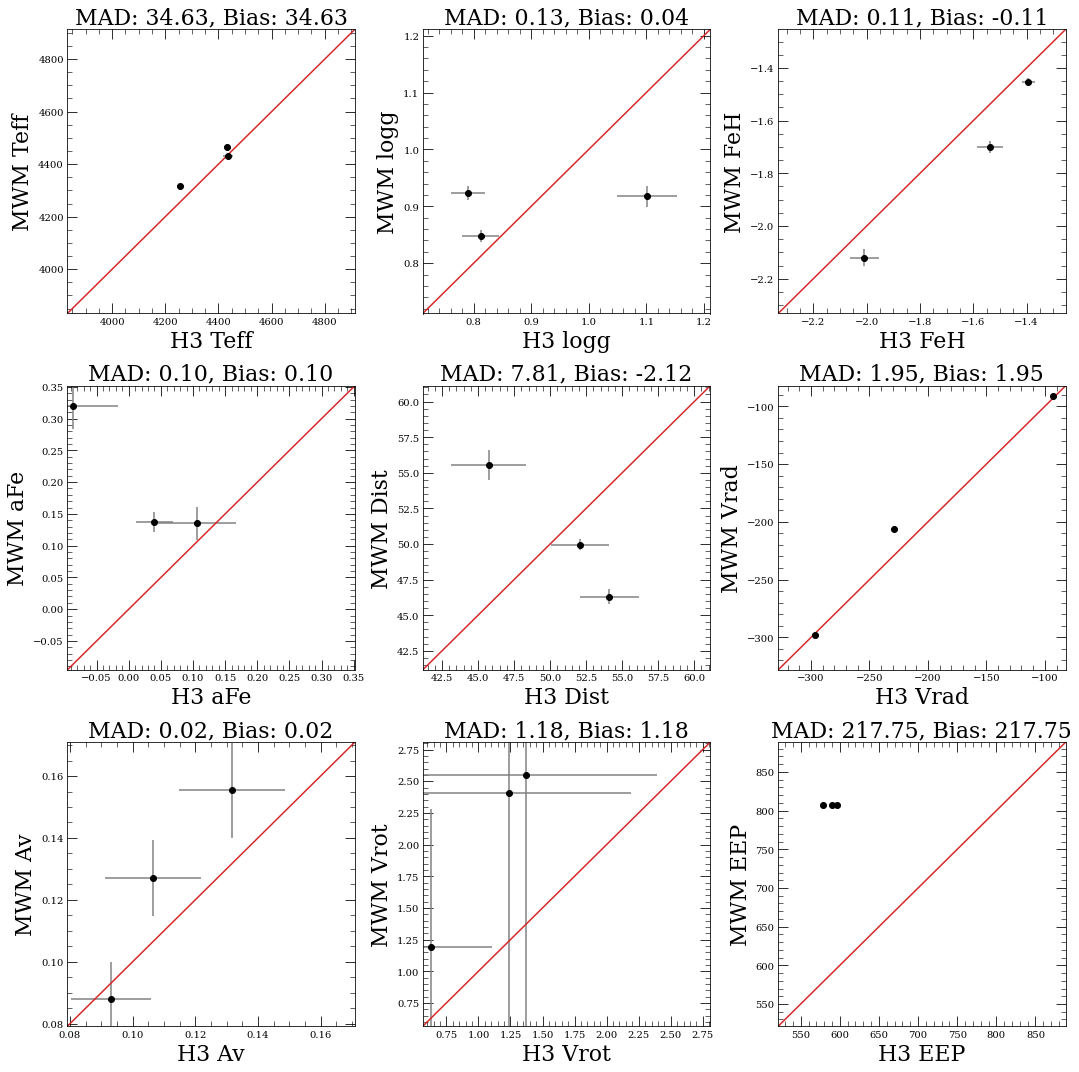

In [14]:
f,axs = plt.subplots(3,3,figsize = (15, 15))
axr = axs.ravel()

labels = ['Teff', 'logg', 'FeH', 'aFe', 'Dist', 'Vrad', 'Av', 'Vrot', 'EEP']

for ii in range(len(labels)):
    plt.sca(axr[ii])
    comp(labels[ii])
    
    plt.xlabel('H3 ' + labels[ii], fontsize = fs)
    plt.ylabel('MWM ' + labels[ii], fontsize = fs)
    
plt.tight_layout()

In [15]:
table[clean][np.abs((table['Vrad'][clean] - table['h3_Vrad'][clean])) > 5]

name,date,specfile,mage_ra,mage_dec,mage_target,mage_decker,mage_binning,mage_mjd,mage_airmass,mage_exptime,tdb_source_id,tdb_ra,tdb_dec,tdb_selection,H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,GAIAEDR3_ID,GAIADR1_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,UNWISE_W1,UNWISE_W2,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,WISE_CC_FLAGS,WISE_EXT_FLAG,ACAT_ID,EEP,EEP_lerr,EEP_uerr,EEP_err,init_FeH,init_FeH_lerr,init_FeH_uerr,init_FeH_err,init_aFe,init_aFe_lerr,init_aFe_uerr,init_aFe_err,init_Mass,init_Mass_lerr,init_Mass_uerr,init_Mass_err,pc_0,pc_0_lerr,pc_0_uerr,pc_0_err,pc_1,pc_1_lerr,pc_1_uerr,pc_1_err,pc_2,pc_2_lerr,pc_2_uerr,pc_2_err,pc_3,pc_3_lerr,pc_3_uerr,pc_3_err,Inst_R,Inst_R_lerr,Inst_R_uerr,Inst_R_err,Teff,Teff_lerr,Teff_uerr,Teff_err,logg,logg_lerr,logg_uerr,logg_err,logR,logR_lerr,logR_uerr,logR_err,FeH,FeH_lerr,FeH_uerr,FeH_err,aFe,aFe_lerr,aFe_uerr,aFe_err,Vrad,Vrad_lerr,Vrad_uerr,Vrad_err,Vrot,Vrot_lerr,Vrot_uerr,Vrot_err,Dist,Dist_lerr,Dist_uerr,Dist_err,Av,Av_lerr,Av_uerr,Av_err,logAge,logAge_lerr,logAge_uerr,logAge_err,Mass,Mass_lerr,Mass_uerr,Mass_err,logL,logL_lerr,logL_uerr,logL_err,Para,Para_lerr,Para_uerr,Para_err,Age,Age_lerr,Age_uerr,Age_err,lnZ,lnL,lnP,chisq_spec,nspecpix,chisq_phot,nbands,R_gal,R_gal_err,X_gal,X_gal_err,Y_gal,Y_gal_err,Z_gal,Z_gal_err,Vx_gal,Vx_gal_err,Vy_gal,Vy_gal_err,Vz_gal,Vz_gal_err,Vr_gal,Vr_gal_err,Vphi_gal,Vphi_gal_err,Vtheta_gal,Vtheta_gal_err,V_tan,V_tan_err,V_gsr,V_gsr_err,Lx,Lx_err,Ly,Ly_err,Lz,Lz_err,Ltot,Ltot_err,E_kin_pot1,E_kin_pot1_err,E_pot_pot1,E_pot_pot1_err,E_tot_pot1,E_tot_pot1_err,circLz_pot1,circLz_pot1_err,circLtot_pot1,circLtot_pot1_err,FLAG,dup,Sgr_l,Sgr_b,Sgr_FLAG,h3_starname,h3_tileID,h3_selID,h3_dateID,h3_fibID,h3_redID,h3_pipeID,h3_H3_ID,h3_TMASS_ID,h3_GAIADR1_ID,h3_GAIADR2_ID,h3_GAIAEDR3_ID,h3_UNWISE_ID,h3_RA,h3_DEC,h3_RA_S,h3_DEC_S,h3_GAIADR2_RA,h3_GAIADR2_RA_ERROR,h3_GAIADR2_DEC,h3_GAIADR2_DEC_ERROR,h3_GAIAEDR3_RA,h3_GAIAEDR3_RA_ERROR,h3_GAIAEDR3_DEC,h3_GAIAEDR3_DEC_ERROR,h3_L,h3_B,h3_xfocal,h3_yfocal,h3_CCDTEMP,h3_mjd,h3_night,h3_RAND,h3_GUIDE,h3_XFIT_RANK,h3_MGIANT,h3_BHB,h3_EBV,h3_APOPAYNE_RA,h3_APOPAYNE_DEC,h3_APOPAYNE_ID,h3_APOPAYNE_TEFF,h3_APOPAYNE_LOGG,h3_APOPAYNE_VMIC,h3_APOPAYNE_VMAC,h3_APOPAYNE_FEH,h3_APOPAYNE_CH,h3_APOPAYNE_NH,h3_APOPAYNE_OH,h3_APOPAYNE_MGH,h3_APOPAYNE_ALH,h3_APOPAYNE_SIH,h3_APOPAYNE_SH,h3_APOPAYNE_KH,h3_APOPAYNE_CAH,h3_APOPAYNE_TIH,h3_APOPAYNE_CRH,h3_APOPAYNE_MNH,h3_APOPAYNE_NIH,h3_APOPAYNE_CUH,h3_APOPAYNE_C12C13,h3_APOPAYNE_CHI2_R,h3_APOPAYNE_QUALITY_FLAG,h3_APOPAYNE_DMATCH,h3_APODR17_ID,h3_APODR17_RA,h3_APODR17_DEC,h3_APODR17_SNR,h3_APODR17_TEFF,h3_APODR17_TEFF_ERR,h3_APODR17_LOGG,h3_APODR17_LOGG_ERR,h3_APODR17_FEH,h3_APODR17_FEH_ERR,h3_APODR17_AFE,h3_APODR17_AFE_ERR,h3_APODR17_MGFE,h3_APODR17_MGFE_ERR,h3_APODR17_RV,h3_APODR17_RV_ERR,h3_APODR17_RV_SCATTER,h3_LAMOST_RA,h3_LAMOST_DEC,h3_LAMOST_ID,h3_LAMOST_SPECCLASS,

### RVS

In [16]:
tab = Table.read('/n/holyscratch01/conroy_lab/vchandra/mage/catalogs/rvs_rcat_V0.0_MSG.fits')

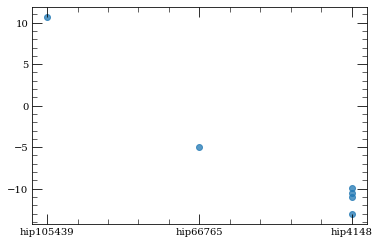

In [17]:
plt.scatter(tab['name'], tab['Vrad'], alpha = 0.75)

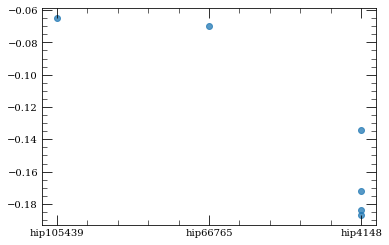

In [18]:
plt.scatter(tab['name'], tab['FeH'], alpha = 0.75)

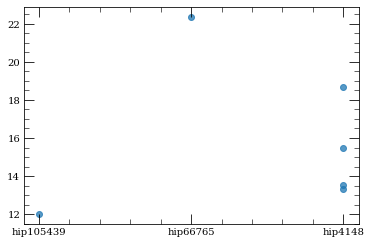

In [19]:
plt.scatter(tab['name'], tab['Vrot'], alpha = 0.75)

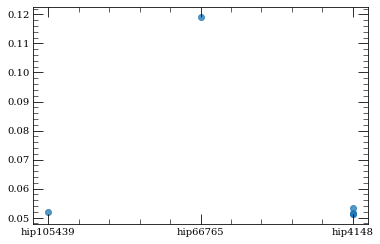

In [20]:
plt.scatter(tab['name'], tab['Av'], alpha = 0.75)